### 1. Preliminaries

In [1]:
import utils as ut

import numpy as np
import pandas as pd
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
ENERGY_PATH = '/net/pc200256/nobackup/users/most/output/LENTIS_PD_02/agg_production/per_country/'
WINDOW = 7
VARIABLE = 'residual' # option 2: total_RE
drop_no_regime = True # set to true if  you want to drop events that occur under 'No-regime' weather regime

date_now = datetime.now()
rundate = '%4.4i%2.2i%2.2i' % (date_now.year,date_now.month,date_now.day)
dir_Output = f'../Results/Data/{rundate}/{VARIABLE}/temporal_composite/'
dir_Figures = f'../Results/Figures/{rundate}/{VARIABLE}/temporal_composite/'

In [3]:
ut.check_make_dir(dir_Output)
ut.check_make_dir(dir_Figures)

data_stacked = ut.load_data(ENERGY_PATH, VARIABLE)
data_rank = data_stacked.compute().rank(dim='event', pct=True)

if VARIABLE == 'total_RE':
    data_rank = 1 - data_rank

In [4]:
df_raw = ut.merge_cluster_data(cluster_path = "../Results/clusters_v1/clusters_all.csv", data_rank = data_rank)

if drop_no_regime:
    df = df_raw[df_raw['cluster_id'] != 4] # remove cluster 4, which is no-regime
    print(f'Fraction of data that was no-regime: {(len(df_raw) - len(df) ) / len(df_raw):.2f} is removed')
else:
    df = df_raw.copy()

Fraction of data that was no-regime: 0.18 is removed


### 2. Define functions

In [5]:
# include no-regime days (cluster 4) or not?
#FIXME: Leap-days get a 'NaN' cluster.

def get_events_df(df, thres):
    df_event = df.query(f'residual >= {thres}').copy().reset_index(drop = True)
    df_event['time_start'] = df_event['time'] - pd.Timedelta(days=7)
    df_event['time_end'] = df_event['time'] + pd.Timedelta(days=7)
    return df_event

In [93]:
def check_overlap(run_times, run, event_time):
    if run in run_times and any(start <= event_time <= end for start, end in run_times[run]):
        return True
    return False

def update_run_times(run_times, run, start_time, end_time):
    if run not in run_times:
        run_times[run] = []
    run_times[run].append((start_time, end_time))
    return run_times

def get_event_timeseries(df_raw, country_name, start_time, end_time, run):
    return df_raw[(df_raw['country_name'] == country_name) & 
                  (df_raw['time'] >= start_time) & 
                  (df_raw['time'] <= end_time) & 
                  (df_raw['run'] == run)]

def plot_data(t, all_series, mean_series, median_series, thres, country_name, num_events):
    if num_events < 1000:
        alpha = 0.05
    elif num_events > 1000 and num_events < 5000:
        alpha = 0.02
    elif num_events > 5000:
        alpha = 0.01

    plt.plot([], [], 'k', alpha = 0.05, label='Events')
    plt.plot(t, all_series.T, 'k', alpha = alpha)
    plt.plot(t, mean_series, 'r', alpha = 1, label = 'Mean')
    plt.plot(t, median_series, 'b', alpha = 1, label = 'Median')

    plt.axhline(y=thres, color='k', linestyle='--')
    plt.xlabel('Days relative to event')
    plt.ylabel('Residual load (percentile)')
    plt.legend()
    plt.savefig(dir_Figures + f'{country_name}_{thres}_{num_events}.png', dpi = 300)

def plot_data_shading(t, all_series, mean_series, median_series, dominant_cluster, thres, country_name, num_events):

    # Calculate percentiles
    p0, p25, p40, p60, p75, p100 = np.percentile(all_series, [0, 25, 40, 60, 75, 100], axis=0)

    # Plot percentiles as shaded areas
    plt.fill_between(t, p0, p100, color='red', alpha=0.1, label='0-100 percentile')
    plt.fill_between(t, p25, p75, color='red', alpha=0.25, label='25-75 percentile')
    plt.fill_between(t, p40, p60, color='red', alpha=0.4, label='40-60 percentile')

    # Plot mean and median
    plt.plot(t, mean_series, 'r', alpha = 1, label = 'Mean')
    plt.plot(t, median_series, 'b', alpha = 1, label = 'Median')

    for i in range(4):
        cluster = np.where(np.asarray(dominant_cluster) == i)
        mean_cluster = all_series[cluster, :].squeeze().mean(axis = 0)
        if len(cluster[0]) > 1:
            plt.plot(t, mean_cluster, label = f'Cluster {i}')

    plt.axhline(y=thres, color='k', linestyle='--')
    plt.xlabel('Days relative to event')
    plt.ylabel('Residual load (percentile)')
    plt.legend()
    plt.savefig(dir_Figures + f'{country_name}_{thres}_{num_events}.png', dpi = 300)

def find_dominant_cluster(event_timeseries, dominant_cluster):
    cluster_counts = event_timeseries['cluster_id'][:8].value_counts()
    if cluster_counts.iloc[0] > 6:
        dominant_cluster.append(int(cluster_counts.index[0]))
    # if difference between first and second cluster is larger than 2 days, then the first one is dominant (arbitrary choice)
    elif cluster_counts.iloc[0] - cluster_counts.iloc[1] > 2: 
        dominant_cluster.append(int(cluster_counts.index[0]))
    elif cluster_counts.iloc[0] - cluster_counts.iloc[1] < 2:
        dominant_cluster.append(5) # no dominant cluster
    

def temporal_composite(df, thres, country_name, num_events, dt = 7, plot = True):
    t = np.arange(-dt, dt + 1)
    df_country_event = df[df['country_name'] == country_name].reset_index(drop = True)

    all_series = np.zeros((num_events, len(t)))
    dominant_cluster = []
    
    run_times = {} # to check for no overlapping timeseries

    unique = 0
    incomplete = 0
    double = 0

    progress_bar = tqdm(total=num_events)

    for i, row in df_country_event.iterrows():
        start_time = str(row['time_start'])
        end_time = str(row['time_end'])
        run = row['run']
        event_time = str(row['time'])

        #REVIEW: if this works. I dont think so, because there should not be values > thres before the event then.
        if check_overlap(run_times, run, event_time):
            double += 1
            continue

        event_timeseries = get_event_timeseries(df_raw, country_name, start_time, end_time, run)
        
        #HACK: Find a solution for this
        if len(event_timeseries) == 15:
            all_series[unique] = event_timeseries['residual'].values
            find_dominant_cluster(event_timeseries, dominant_cluster)
            unique += 1
            progress_bar.update()

            if unique == num_events:
                break
            if run not in run_times:
                run_times[run] = []
            run_times[run].append((start_time, end_time))
        elif len(event_timeseries) < 15:
            incomplete += 1

    dominant_cluster = np.asarray(dominant_cluster)
    
    mean_series = all_series.mean(axis=0)
    median_series = np.median(all_series, axis = 0)

    print(f'{incomplete} timeseries incomplete, {double} events with overlapping timeseries')
    
    if plot:
        plot_data_shading(t, all_series, mean_series, median_series, dominant_cluster, thres, country_name, num_events)

    return all_series, mean_series, median_series, incomplete, double

### 3. Perform analysis of temporal composites

  0%|          | 0/100 [00:00<?, ?it/s]

33 timeseries incomplete, 103 events with overlapping timeseries


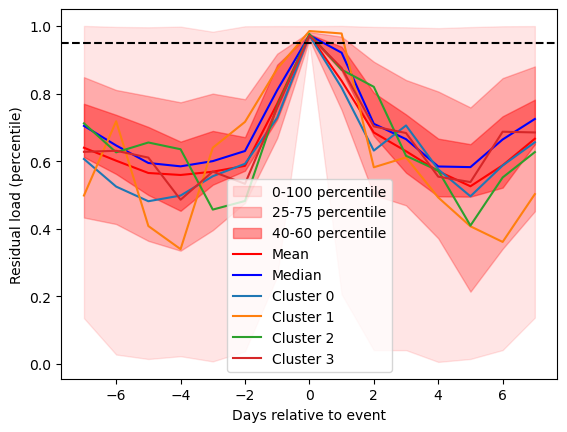

In [79]:
df_event = get_events_df(df_raw, 0.95)
all_series, mean_series, median_series, incomplete, double = temporal_composite(df_event, 0.95, 'NLD', 100)

  0%|          | 0/100 [00:00<?, ?it/s]

79 timeseries incomplete, 414 events with overlapping timeseries


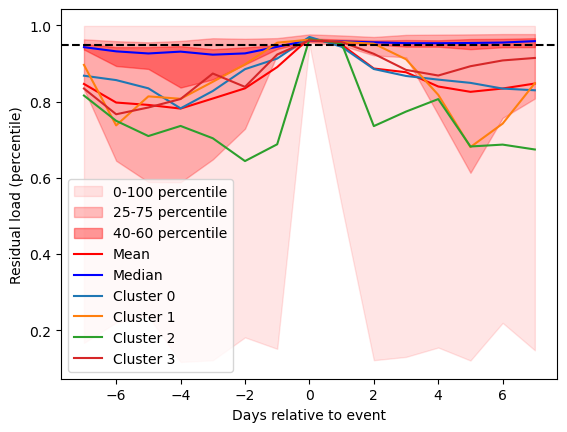

In [80]:
df_event = get_events_df(df_raw, 0.95)
all_series, mean_series, median_series, incomplete, double = temporal_composite(df_event, 0.95, 'NOR', 100)

  0%|          | 0/100 [00:00<?, ?it/s]

10 timeseries incomplete, 320 events with overlapping timeseries


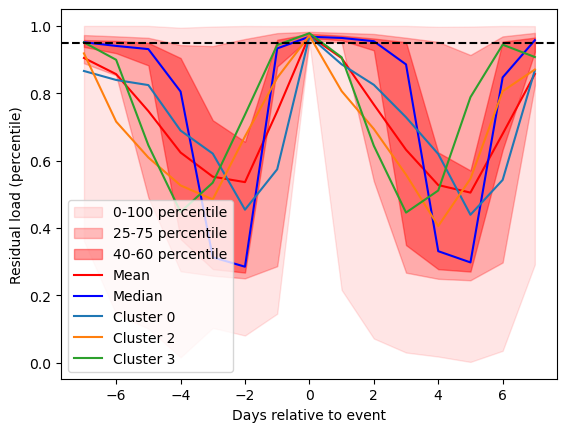

In [94]:
df_event = get_events_df(df_raw, 0.95)
all_series, mean_series, median_series, incomplete, double = temporal_composite(df_event, 0.95, 'ITA', 100)

  0%|          | 0/1000 [00:00<?, ?it/s]

217 timeseries incomplete, 1050 events with overlapping timeseries


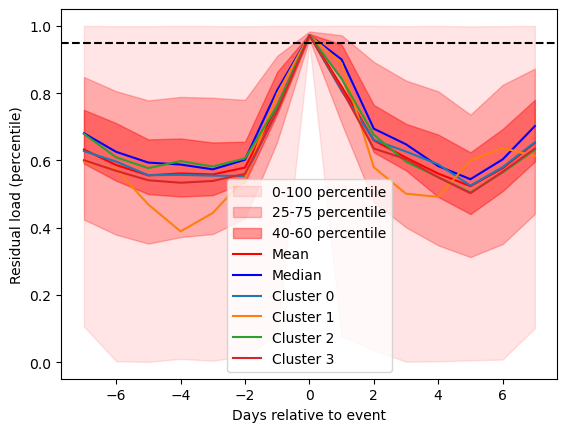

In [95]:
df_event = get_events_df(df_raw, 0.95)
all_series, mean_series, median_series, incomplete, double = temporal_composite(df_event, 0.95, 'NLD', 1000)